### Classifying Ancient Egyptian Landmarks

Created by Josh Sanchez. Last updated February 1, 2024.

This dataset consists of roughly 3,500 images of Ancient Egyptian landmarks.
The dataset was created by user Marvy Ayman Halim on Kaggle and can be found at: https://www.kaggle.com/datasets/marvyaymanhalim/ancient-egyptian-landmarks-dataset.

In [1]:
# data preprocessing
import os
import shutil
import pandas as pd
import numpy as np

# data visualization
%matplotlib inline
from matplotlib import pyplot as plt
from pylab import *
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import CategoricalColorMapper

# data scaling
from preamble import *
from sklearn.model_selection import train_test_split

# data analysis
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Data Preprocessing
Import the data and clean up the folder and file names. Then make the image dataset into a .csv file. 

**Note:** I manually removed the Node.js folder from the dataset because it does not pertain to the project. The original data can be found under the folder called *Data*. The *raw_data* folder contains the original dataset minus the Node.js folder. The *processed_data folder* contains the properly formatted folder and file names.

Ensure that you do not have a processed_data folder on your machine, just the raw_data folder, before you run the following cell.

In [2]:
filenames = []
labels = []

# create the processed_data folder
try:
    os.mkdir(os.path.join(os.getcwd(), "processed_data"))
except OSError as error:
    print(error)

processed_data_dir = os.path.join(os.getcwd(), "processed_data")

for folder in os.scandir("raw_data"):

    # if the selected item is not a directory
    if not folder.is_dir():
        continue


    # lowercase the folder name and replace space with underscore
    changed_folder_name = folder.name.lower()
    changed_folder_name = changed_folder_name.replace(" ", "_")


    # add folder to processed_data
    try:
        os.mkdir(os.path.join(processed_data_dir, changed_folder_name))
    except OSError as error:
        print(error)

    processed_folder = os.path.join(processed_data_dir, changed_folder_name)

    # pull filename and store in filenames for dataframe
    for file in os.scandir(folder.path):
        # if the folder is empty
        if len(folder.path) == 0:
            continue

        # lowercase the file name and replace space with underscore
        changed_file_name = file.name.lower()
        changed_file_name = changed_file_name.replace(" ", "_")


        # copy the file to its correct folder in processed_data
        shutil.copy(file, processed_folder)

        # rename the file to the edited file name
        raw_file = os.path.join(processed_folder, file.name)                 # the original, unedited file name
        processed_file = os.path.join(processed_folder, changed_file_name)   # the edited file name

        try:
            os.rename(raw_file, processed_file)
        except OSError as error:
            print(error)

        # store properly formatted folder name as a label
        labels.append(changed_folder_name)

        # store filename as a filename
        filenames.append(changed_file_name)

        # create a dataframe by making a tuple of the filename and label
        df = pd.DataFrame(list(zip(filenames, labels)), columns=["image", "label"])

# change the file to a csv
df.to_csv("ancient_egyptian_dataset.csv", index=False)

# Describe the sample and features

In [3]:
df.head(10)

image      label
0  15634726773_a8ac65d6ef_m_-_copy.jpg  akhenaten
1         19281291360_5a49331215_m.jpg  akhenaten
2          2906415757_50c2bc0414_m.jpg  akhenaten
3         41957529164_421e9f622f_m.jpg  akhenaten
4          4902788942_1c4ee56ede_m.jpg  akhenaten
5          7731634374_fe4e21a493_m.jpg  akhenaten
6          9711457465_051cf60521_n.jpg  akhenaten
7                              a.1.jpg  akhenaten
8                             a.10.jpg  akhenaten
9                             a.11.jpg  akhenaten

# Understanding patterns/trends in the data

In order to understand the data, it must first be described. The code below shows that there are 1320 "unique" images (meaning image filenames) and 22 unique labels. At this point, the model might attempt to cluster the images into 22 distinct groups.

In [4]:
df.describe()

image           label
count    3575            3575
unique   1320              22
top     8.jpg  khafre_pyramid
freq       18             444

The below code shows the number of images for each label.

In [5]:
df["label"].value_counts()

label
khafre_pyramid                             444
hatshepsut                                 349
sphinx                                     345
bent_pyramid_for_senefru                   335
colossoi_of_memnon                         234
the_great_temple_of_ramesses_ii            219
mask_of_tutankhamun                        201
ramessum                                   189
menkaure_pyramid                           120
statue_of_king_zoser                       109
nefertiti                                  104
colossal_statue_of_ramesses_ii              99
temple_of_kom_ombo                          99
amenhotep_iii_and_tiye                      98
ramses_ii_red_granite_statue                97
akhenaten                                   95
hatshepsut_face                             84
goddess_isis_with_her_child                 84
pyramid_of_djoser                           76
bust_of_ramesses_ii                         70
statue_of_tutankhamun_with_ankhesenamun     67
temple_

# Data transformations
Scale and then grayscale images. Overwrite the image file in processed_data with the transformed images.

In [6]:
def resize_with_aspect_ratio(image, size):
    """Resizes an image with padding to maintain aspect ratio.

    Args:
        image: A PIL.Image.Image object.
        size: Tuple representing the desired output size (width, height).

    Returns:
        A PIL.Image.Image object of the resized image.
    """

    # if the image is already a square
    if image.width == image.height:
        square_img = image.resize(size)
        # print("image is already a square- resize without padding: ", square_img.size)

        return square_img

    # if the image's height is smaller than its width
    elif image.width > image.height:
        # pad the image with black bars to get the image to a square size of its width
        square_img = Image.new(image.mode, (image.width, image.width))
        square_img.paste(image, (0, (image.width - image.height) // 2))

        # resize the image
        resized_img = square_img.resize(size)
        # print("image height is smaller than width- resize with padding for height: ", resized_img.size)

        return resized_img

    # if the image's width is smaller than its height
    else:
        square_img = Image.new(image.mode, (image.height, image.height))
        square_img.paste(image, ((image.height - image.width) // 2, 0))

        # resize the image
        resized_img = square_img.resize(size)
        # print("image width smaller than height- resize with padding for width: ", resized_img.size)

        return resized_img

In [7]:
def resize_and_grayscale(image_path):
    """Resizes and grayscales an image.

    Args: image_path: String representing the path to the image file.

    Returns: A PIL.Image.Image object of the resized and grayscale image.
    """

    image = Image.open(image_path)
    size = (180, 180)

    # If the image is already 180x180, just grayscale it
    if image.size == size:
        gray_image = image.convert("L")  # Convert to grayscale
        return gray_image

    # Resize with padding or direct resizing based on aspect ratio
    resized_img = resize_with_aspect_ratio(image, size)

    # Convert to grayscale
    gray_img = resized_img.convert("L")

    # Save the grayscale image
    gray_img.save(image_path)

    return gray_img

In [8]:
def display_image(image_list, index):
    """Displays a specific image from a specified image_list.

    Args: image_list: List containing either the non aspect preserved or the aspect preserved NumPy representations of the images.

    Returns: A PIL.Image object of the image.
    """
    # Acces the specific NumPy array from the list
    img_array = image_list[index]

    # Convert the NumPy array to a PIL Image object (assuming uint8 data type)
    img = Image.fromarray(img_array.astype("uint8"))

    return img

In [9]:
# Resize and grayscale all the images without preserving aspect ratio
img_list = []
for image, label in df.values:
    img_path = os.path.join(processed_data_dir, label, image)

    try:
        # Open image using PIL
        img = Image.open(img_path)

        # Resize the image
        resized_img = img.resize((180, 180))  # This does not preserve aspect ratio

        # Convert to grayscale
        gray_img = resized_img.convert("L")

        # Append the resized and grayscaled image to the list
        img_list.append(np.array(gray_img))
    except FileNotFoundError:
        print(f"Error: Image not found - {img_path}")  # Handle file not found error

In [10]:
# Resize and grayscale all the images preserving aspect ratio

img_list_aspect_preserved = []
for image, label in df.values:
    img_path = os.path.join(processed_data_dir, label, image)

    try:
        # Open image using PIL
        img = Image.open(img_path)

        # Resize and grayscale the image
        resized_and_grayscaled_img = resize_and_grayscale(img_path)

        # Append the resized and grayscaled image to the list
        img_list_aspect_preserved.append(np.array(resized_and_grayscaled_img))
    except FileNotFoundError:
        print(f"Error: Image not found - {img_path}")  # Handle file not found error

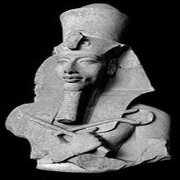

In [11]:
# Show the first image of the non aspect preserved list
display_image(img_list, 0)

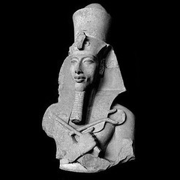

In [12]:
# Show the image of the aspect preserved list
display_image(img_list_aspect_preserved, 0)

# Contours
Showing the contours of the aspect preserved and non-aspect preserved images to identify differences.

(0.5, 179.5, 0.5, 179.5)

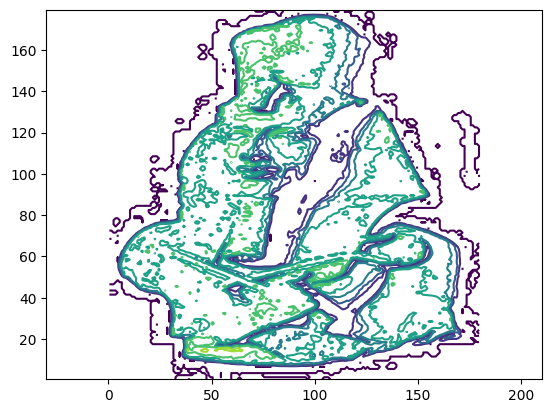

In [13]:
# Show the contours of the first image (non-aspect preserved)
figure()
contour(img_list[0], origin='image')
axis('equal')

(0.5, 179.5, 0.5, 179.5)

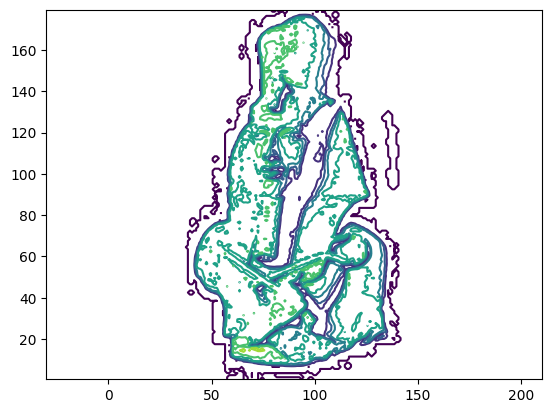

In [14]:
# Show the contours of the first image with preserved aspect ratio
figure()
contour(img_list_aspect_preserved[0], origin='image')
axis('equal')

(0.5, 179.5, 0.5, 179.5)

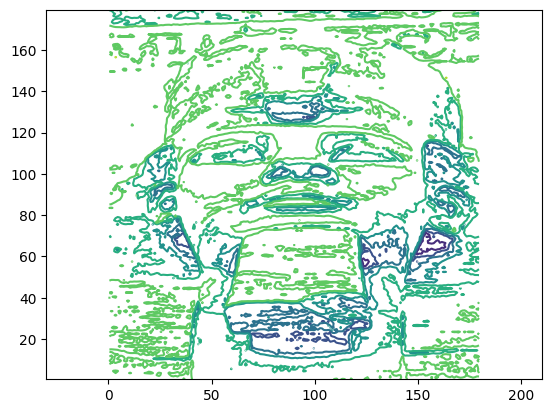

In [15]:
# Show the contours of the last image (non-aspect preserved)
figure()
contour(img_list[3574], origin='image')
axis('equal')

(0.5, 179.5, 0.5, 179.5)

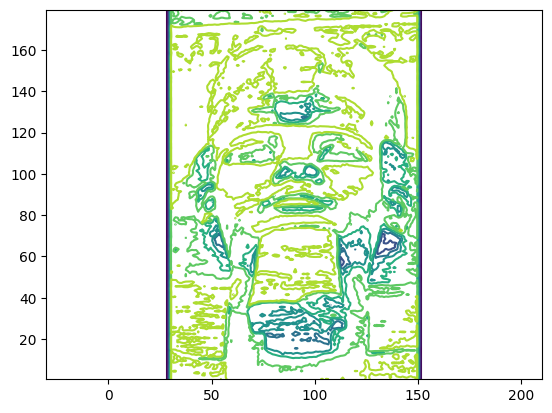

In [16]:
# Show the contours for the last image in the dataset with preserved aspect ratio
figure()
contour(img_list_aspect_preserved[3574], origin="image")
axis("equal")

(0.5, 179.5, 0.5, 179.5)

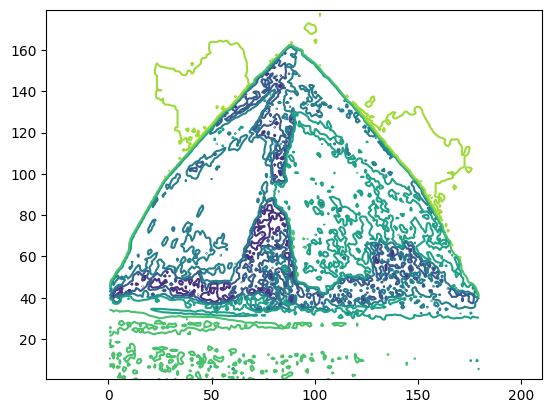

In [17]:
# Show the contours of the bent pyramid for senefru image (non-aspect preserved)
figure()
contour(img_list[194], origin='image')
axis('equal')

(0.5, 179.5, 0.5, 179.5)

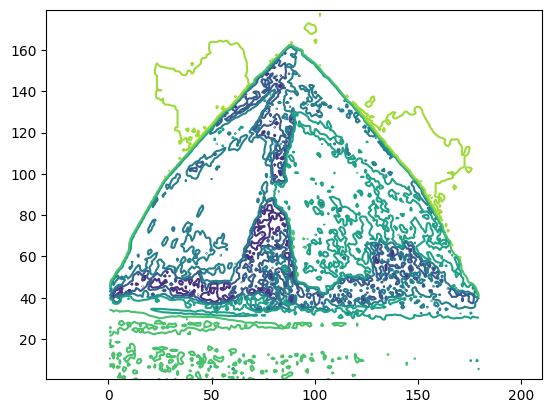

In [18]:
# Show the contours for the bent_pyramid_for_senefru with preserved aspect ratio
figure()
contour(img_list_aspect_preserved[194], origin="image")
axis("equal")

# Flattening
Flattening the images in the dataset. Historgram shows the distribution of pixel identities across the image and how they vary in aspect preserved vs non-aspect preserved images.

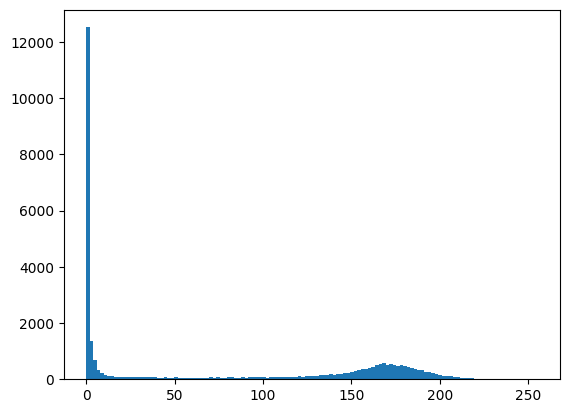

In [19]:
# Show the histogram of the flattened contours of the first image in the dataset without preserved aspect ratio.
figure()
hist(img_list[0].flatten(), 128)
show()

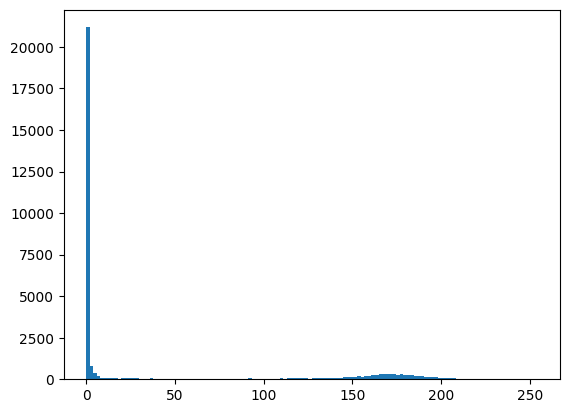

In [20]:
# Show the histogram of the flattened contours of the first image in the dataset with preserved aspect ratio.
figure()
hist(img_list_aspect_preserved[0].flatten(), 128)
show()

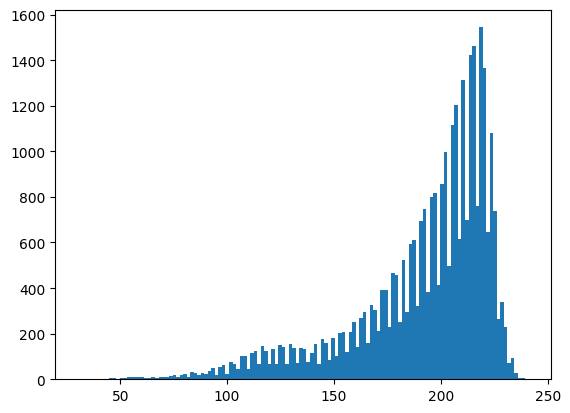

In [21]:
# Show the histogram of the flattened contours of the last image in the dataset without preserved aspect ratio.
figure()
hist(img_list[3574].flatten(), 128)
show()

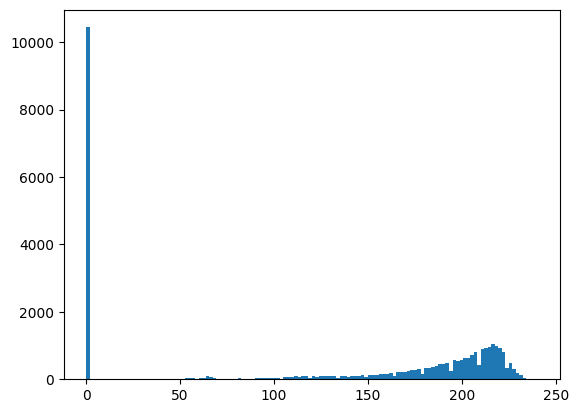

In [22]:
# Show the histogram of the flattened contours of the last image in the dataset with preserved aspect ratio.
figure()
hist(img_list_aspect_preserved[3574].flatten(), 128)
show()

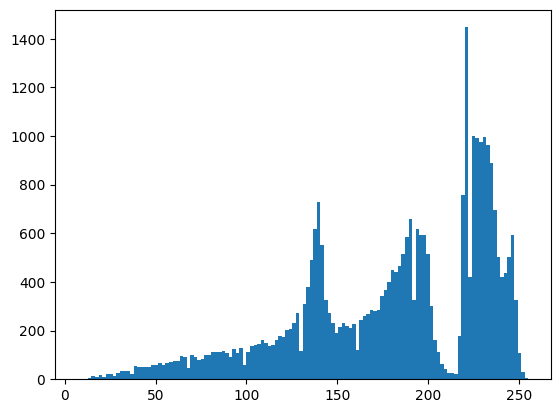

In [23]:
# Show the historgram of the flattened contours of the bent_pyramid_for_senefru image without preserved aspect ratio.
figure()
hist(img_list[194].flatten(), 128)
show()

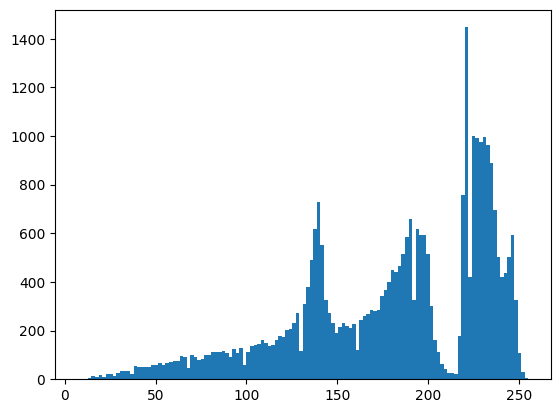

In [24]:
# Show the historgram of the flattened contours of the bent_pyramid_for_senefru image with preserved aspect ratio.
figure()
hist(img_list_aspect_preserved[194].flatten(), 128)
show()

Contours will not be used in the clustering models but is a good visual representation of the potential different clusters that the models will give based on aspect ratio. Flattening the image with and without aspect ratio preservation will be used in the clustering models. The histograms above reveal that aspect ratio preservation could lead to potentially different image clusters. Let's permenantly flatten the images and add that NumPy array as a new column to the data frame. 

In [25]:
# Create an empty list to store flattened images
flattened_images = []

# Iterate over the img_list to flatten the images
for img_array in img_list:
    flattened_img = img_array.flatten()
    flattened_images.append(flattened_img)

# Add a new column named 'flattened_image' to the DataFrame
df["flattened_image"] = flattened_images

In [26]:
# Create an empty list to store flattened images
flattened_images_aspect_ratio = []

# Iterate over the img_list to flatten the images
for img_array in img_list:
    flattened_img = img_array.flatten()
    flattened_images_aspect_ratio.append(flattened_img)

# Add a new column named 'flattened_image' to the DataFrame
df["flattened_image_aspect_ratio"] = flattened_images_aspect_ratio

In [27]:
# Check to see if new column was added with the appropriate values
df.head()

image      label  \
0  15634726773_a8ac65d6ef_m_-_copy.jpg  akhenaten   
1         19281291360_5a49331215_m.jpg  akhenaten   
2          2906415757_50c2bc0414_m.jpg  akhenaten   
3         41957529164_421e9f622f_m.jpg  akhenaten   
4          4902788942_1c4ee56ede_m.jpg  akhenaten   

                                     flattened_image  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 2...   
2  [63, 52, 45, 46, 46, 46, 46, 42, 42, 43, 43, 4...   
3  [255, 255, 255, 254, 255, 255, 255, 255, 255, ...   
4  [244, 246, 247, 248, 248, 241, 246, 247, 247, ...   

                        flattened_image_aspect_ratio  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 2...  
2  [63, 52, 45, 46, 46, 46, 46, 42, 42, 43, 43, 4...  
3  [255, 255, 255, 254, 255, 255, 255, 255, 255, ...  
4  [244, 246, 247, 248, 248, 241, 246, 247, 247, ...

# Unsupervised K-means clustering using non-aspect preserved images

In [28]:
# Build the unsupervised clustering model on non-aspect preserved image
unsupervised_kmeans = KMeans(n_clusters=2, random_state=42)
unsupervised_kmeans.fit(flattened_images)

# Predict cluster labels for training and testing data
y_unsupervised_kmeans = unsupervised_kmeans.predict(flattened_images)

c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


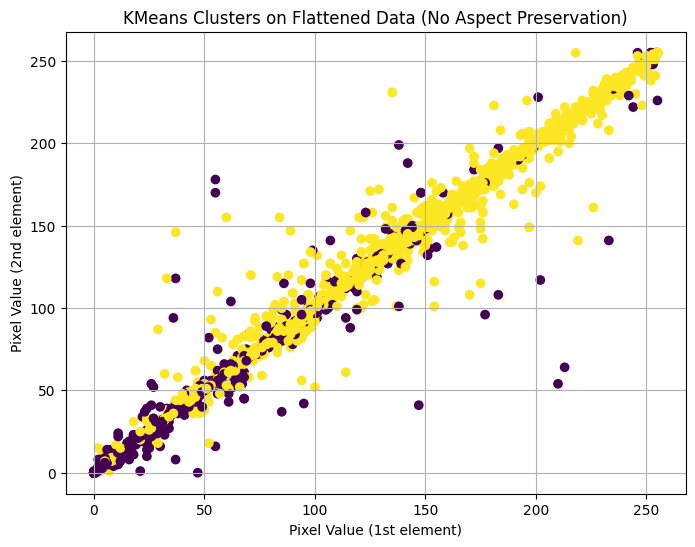

In [29]:
x_data = []
y_data = []

for image in flattened_images:
    # Access pixel values directly from the flattened array
    x_data.append(image[0])  # Assuming the first element is the "x" value
    y_data.append(image[1])  # Assuming the second element is the "y" value

# Create the scatter plot using separate lists for x and y data
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, c=y_unsupervised_kmeans, cmap="viridis")
plt.xlabel("Pixel Value (1st element)")
plt.ylabel("Pixel Value (2nd element)")
plt.title("KMeans Clusters on Flattened Data (No Aspect Preservation)")
plt.grid(True)
plt.show()

This doesn't look that good. There's a small purple cluster on the bottom left, but otherwise this is uninformative. Let's see if PCA can reveal anything beneficial.

# Unsupervised K-means clustering using non-aspect preserved images and PCA reduction

In [30]:
# Perform PCA (non-aspect preserved)
pca = PCA(n_components=100, random_state=22)
pca.fit(flattened_images)
X = pca.transform(flattened_images)

# print("Original shape: {}".format(str(img_list.shape)))
print("Reduced shape: {}".format(str(X.shape)))

Reduced shape: (3575, 100)


In [31]:
# Build the unsupervised clustering model on non-aspect preserved image
unsupervised_kmeans_pca = KMeans(n_clusters=2, random_state=42)
unsupervised_kmeans_pca.fit(X)

# Predict cluster labels for training and testing data
y_unsupervised_kmeans_pca = unsupervised_kmeans_pca.predict(X)

c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


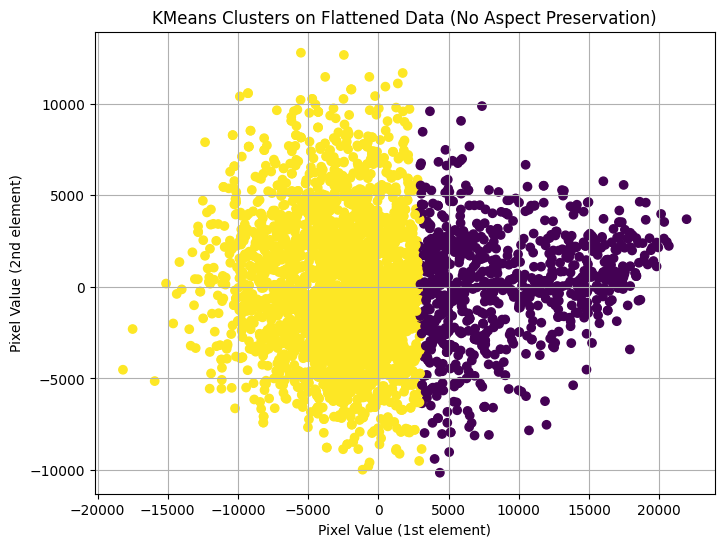

In [32]:
x_data = []
y_data = []
for image in X:
    # Access pixel values directly from the flattened array
    x_data.append(image[0])  # Assuming the first element is the "x" value
    y_data.append(image[1])  # Assuming the second element is the "y" value

# Create the scatter plot using separate lists for x and y data
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, c=y_unsupervised_kmeans, cmap="viridis")
plt.xlabel("Pixel Value (1st element)")
plt.ylabel("Pixel Value (2nd element)")
plt.title("KMeans Clusters on Flattened Data (No Aspect Preservation)")
plt.grid(True)
plt.show()

A better visualization of the purple vs yellow cluster, but there are still no clearly defined clusters here. Perhaps t-SNE will be better.

# Unsupervised t-SNE clustering using non-aspect preserved images

In [33]:
img_array = np.array(flattened_images)
unsupervised_tsne = TSNE(n_components=2, random_state=42)
X_tsne = unsupervised_tsne.fit_transform(img_array)

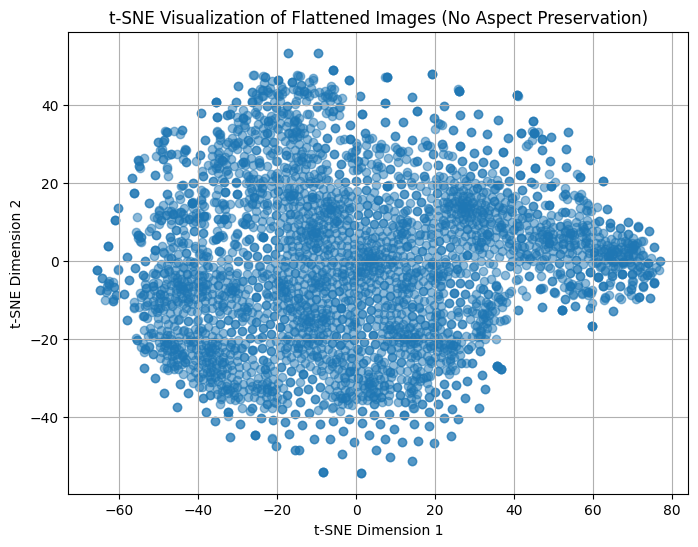

In [34]:
# Extract the two reduced dimensions from tSNE
tsne_features_1 = X_tsne[:, 0]
tsne_features_2 = X_tsne[:, 1]

# Create a scatter plot for the reduced dimensions
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features_1, tsne_features_2, alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Flattened Images (No Aspect Preservation)")
plt.grid(True)
plt.show()

This shows some hints of clusters, shown by the darker blue spots, but no clear clusters. Perhaps using PCA can reveal the underlying clusters?

# Unsupervised t-SNE clustering using non-aspect preserved images with PCA reduction

In [35]:
unsupervised_tsne = TSNE(n_components=2, random_state=42)
X_tsne_pca = unsupervised_tsne.fit_transform(X)

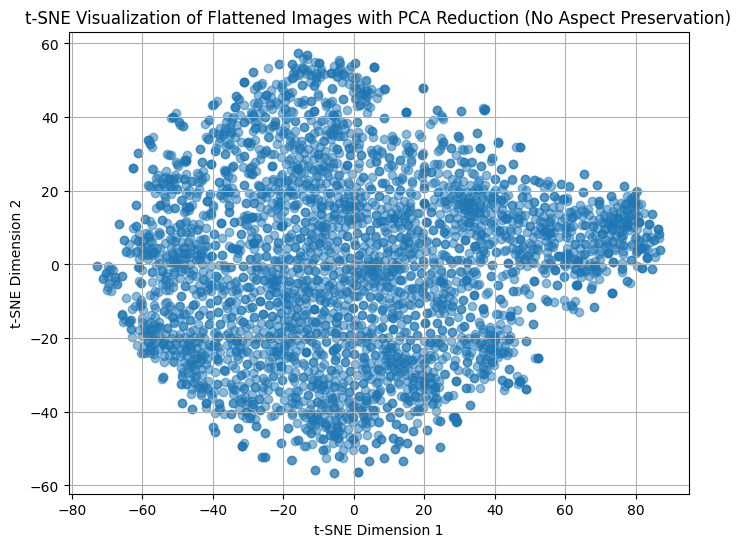

In [36]:
# Extract the two reduced dimensions from tSNE
tsne_features_1 = X_tsne_pca[:, 0]
tsne_features_2 = X_tsne_pca[:, 1]

# Create a scatter plot for the reduced dimensions
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features_1, tsne_features_2, alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Flattened Images with PCA Reduction (No Aspect Preservation)")
plt.grid(True)
plt.show()

# Unsupervised K-means clustering using aspect preserved images

In [37]:
# Build the unsupervised clustering model on non-aspect preserved image
unsupervised_kmeans = KMeans(n_clusters=2, random_state=42)
unsupervised_kmeans.fit(flattened_images_aspect_ratio)

# Predict cluster labels for training and testing data
y_unsupervised_kmeans = unsupervised_kmeans.predict(flattened_images_aspect_ratio)

c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


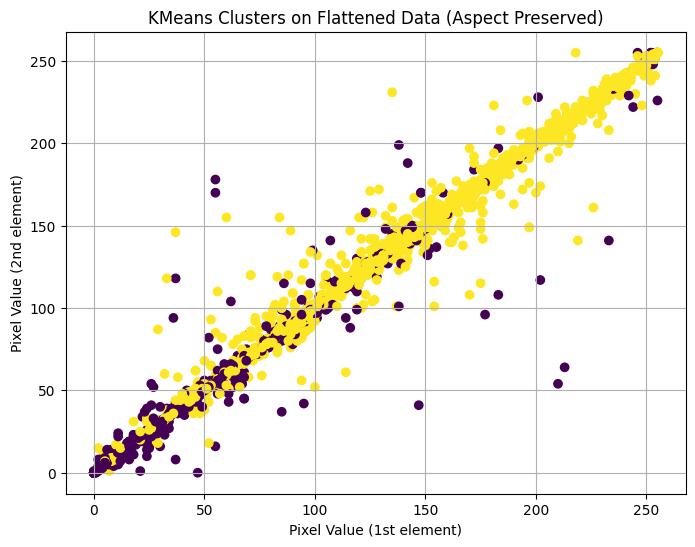

In [38]:
x_data = []
y_data = []

for image in flattened_images_aspect_ratio:
    # Access pixel values directly from the flattened array
    x_data.append(image[0])  # Assuming the first element is the "x" value
    y_data.append(image[1])  # Assuming the second element is the "y" value

# Create the scatter plot using separate lists for x and y data
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, c=y_unsupervised_kmeans, cmap="viridis")
plt.xlabel("Pixel Value (1st element)")
plt.ylabel("Pixel Value (2nd element)")
plt.title("KMeans Clusters on Flattened Data (Aspect Preserved)")
plt.grid(True)
plt.show()

# Unsupervised K-means clustering using aspect preserved images and PCA reduction

In [39]:
# Perform PCA (non-aspect preserved)
pca = PCA(n_components=100, random_state=22)
pca.fit(flattened_images_aspect_ratio)
X = pca.transform(flattened_images_aspect_ratio)

# print("Original shape: {}".format(str(img_list.shape)))
print("Reduced shape: {}".format(str(X.shape)))

Reduced shape: (3575, 100)


In [40]:
# Build the unsupervised clustering model on non-aspect preserved image
unsupervised_kmeans_pca = KMeans(n_clusters=2, random_state=42)
unsupervised_kmeans_pca.fit(X)

# Predict cluster labels for training and testing data
y_unsupervised_kmeans_pca = unsupervised_kmeans_pca.predict(X)

c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


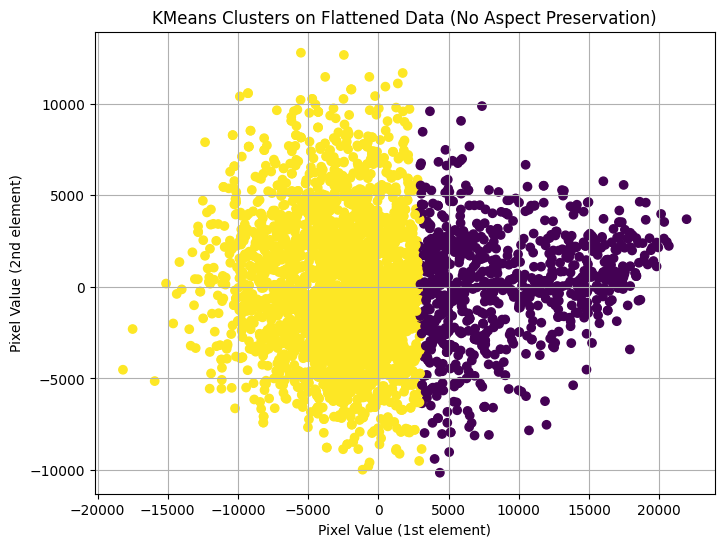

In [45]:
x_data = []
y_data = []
for image in X:
    # Access pixel values directly from the flattened array
    x_data.append(image[0])  # Assuming the first element is the "x" value
    y_data.append(image[1])  # Assuming the second element is the "y" value

# Create the scatter plot using separate lists for x and y data
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, c=y_unsupervised_kmeans, cmap="viridis")
plt.xlabel("Pixel Value (1st element)")
plt.ylabel("Pixel Value (2nd element)")
plt.title("KMeans Clusters on Flattened Data (No Aspect Preservation)")
plt.grid(True)
plt.show()

# Unsupervised t-SNE using aspect preserved images

In [41]:
img_array = np.array(flattened_images_aspect_ratio)
unsupervised_tsne = TSNE(n_components=2, random_state=42)
X_tsne = unsupervised_tsne.fit_transform(img_array)

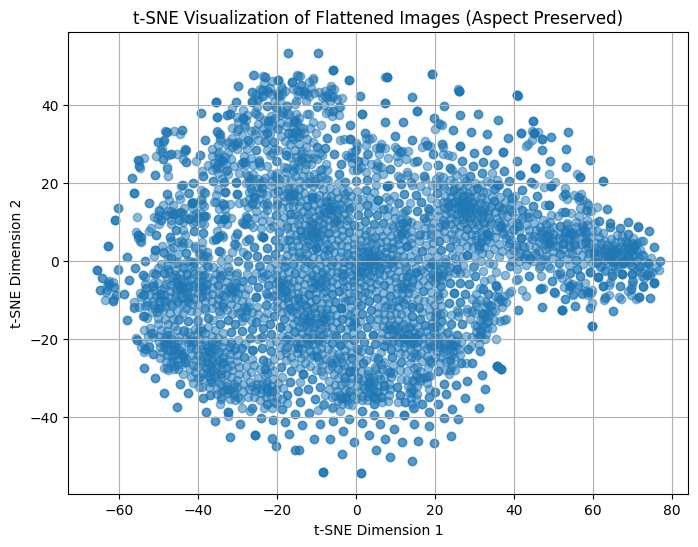

In [42]:
# Extract the two reduced dimensions from tSNE
tsne_features_1 = X_tsne[:, 0]
tsne_features_2 = X_tsne[:, 1]

# Create a scatter plot for the reduced dimensions
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features_1, tsne_features_2, alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Flattened Images (Aspect Preserved)")
plt.grid(True)
plt.show()

# Unsupervised t-SNE using aspect ratio preserved images and PCA reduction

In [43]:
unsupervised_tsne = TSNE(n_components=2, random_state=42)
X_tsne_pca = unsupervised_tsne.fit_transform(X)

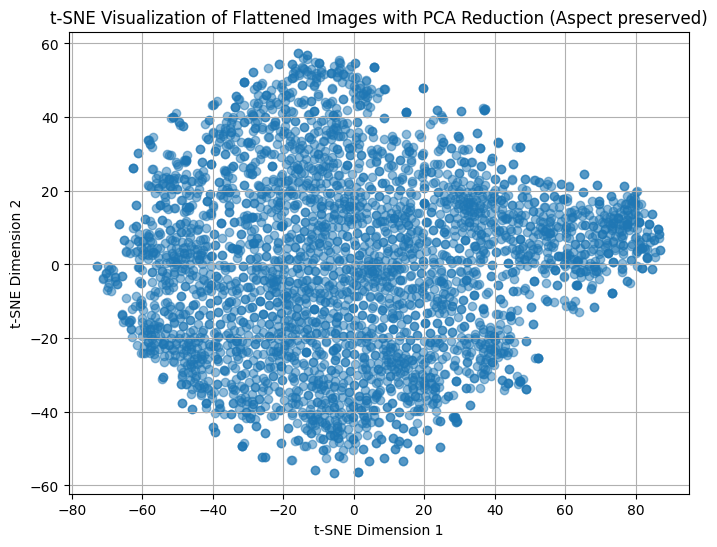

In [44]:
# Extract the two reduced dimensions from tSNE
tsne_features_1 = X_tsne_pca[:, 0]
tsne_features_2 = X_tsne_pca[:, 1]

# Create a scatter plot for the reduced dimensions
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features_1, tsne_features_2, alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Flattened Images with PCA Reduction (Aspect preserved)")
plt.grid(True)
plt.show()

___
# Anything below this line will NOT be discussed in the final paper
# Supervised approach
# Spliting the data for supervised approach
Note: the visualization models have logic errors as there are 2502 factors (one for each image) which is not the goal.

In [46]:
# Split the DataFrame for train and test sets (non-aspect preserved)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)

# Extract image paths and labels for training and testing sets
X_train = []
y_train = []
for index, row in df_train.iterrows():
    image_path = row["image"]
    label = row["label"]
    X_train.append(img_list[index])  # Access corresponding image from non-aspect preserved NumPy array list
    y_train.append(label)

print(y_train[0:22])

X_test = []
y_test = []
for index, row in df_test.iterrows():
    image_path = row["image"]
    label = row["label"]
    X_test.append(img_list[index])
    y_test.append(label)

# Convert lists to NumPy arrays for easier handling
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape images to 2D (samples x features)
X_train = X_train.reshape(-1, 180 * 180)
X_test = X_test.reshape(-1, 180 * 180)

print("\nX_train shape (reshaped):", X_train.shape)
print("X_train shape (reshaped):", X_test.shape)

['hatshepsut', 'colossoi_of_memnon', 'sphinx', 'mask_of_tutankhamun', 'khafre_pyramid', 'sphinx', 'hatshepsut', 'khafre_pyramid', 'pyramid_of_djoser', 'statue_of_tutankhamun_with_ankhesenamun', 'colossal_statue_of_ramesses_ii', 'sphinx', 'pyramid_of_djoser', 'bent_pyramid_for_senefru', 'ramses_ii_red_granite_statue', 'temple_of_isis_in_philae', 'hatshepsut', 'sphinx', 'khafre_pyramid', 'khafre_pyramid', 'temple_of_kom_ombo', 'statue_of_tutankhamun_with_ankhesenamun']
X_train shape: (2502, 180, 180)
y_train shape: (2502,)
X_test shape: (1073, 180, 180)
y_test shape: (1073,)

X_train shape (reshaped): (2502, 32400)
X_train shape (reshaped): (1073, 32400)


# Dimensionality reduction - PCA

In [47]:
# Perform PCA (non-aspect preserved)
pca = PCA(n_components=100, random_state=22)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original shape: {}".format(str(X_train.shape)))
print("Reduced shape: {}".format(str(X_train_pca.shape)))

print("\nOriginal shape: {}".format(str(X_test.shape)))
print("Reduced shape: {}".format(str(X_test_pca.shape)))

Original shape: (2502, 32400)
Reduced shape: (2502, 100)

Original shape: (1073, 32400)
Reduced shape: (1073, 100)


C:\Users\rsant\AppData\Local\Temp\ipykernel_23820\2837980048.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_colors)
C:\Users\rsant\AppData\Local\Temp\ipykernel_23820\2837980048.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cmap(y_train_int), cmap=cmap)


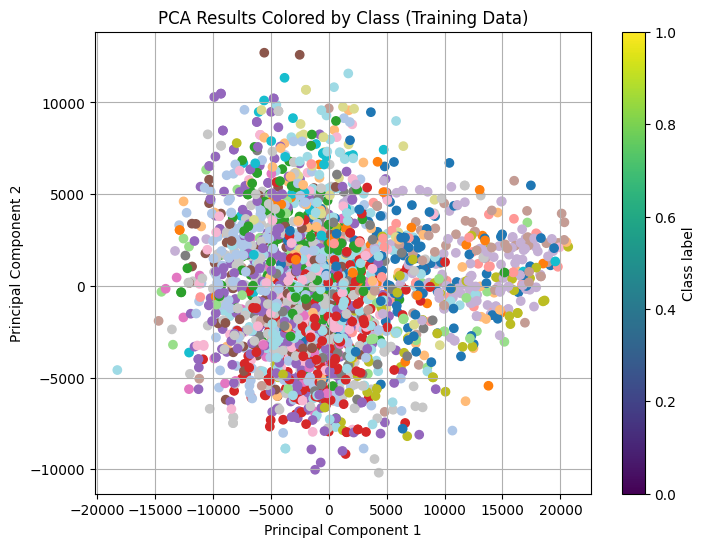

In [48]:
# Getting unique labels for colormap
unique_labels = np.unique(y_train)

label_to_int = {label: i for i, label in enumerate(unique_labels)}
y_train_int = np.array([label_to_int[label] for label in y_train])  # Encode labels numerically

num_colors = len(unique_labels)
cmap = cm.get_cmap('tab20', num_colors)

# Plot PCA results of X_train
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=cmap(y_train_int), cmap=cmap)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Results Colored by Class (Training Data)")
plt.grid(True)
plt.colorbar(label="Class label")
plt.show()

# K-means Clustering

c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


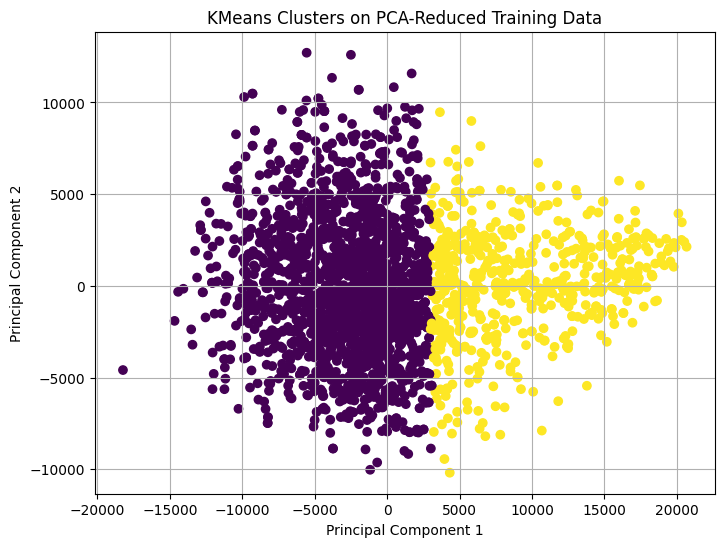

In [50]:
# build the clustering model with PCA
kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_pca.fit(X_train_pca)

# Predict cluster labels for training and testing data
y_train_kmeans_pca = kmeans_pca.predict(X_train_pca)
y_test_kmeans_pca = kmeans_pca.predict(X_test_pca)

# Create a scatter plot for training data colored by cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_kmeans_pca, cmap="viridis")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans Clusters on PCA-Reduced Training Data")
plt.grid(True)
plt.show()

c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


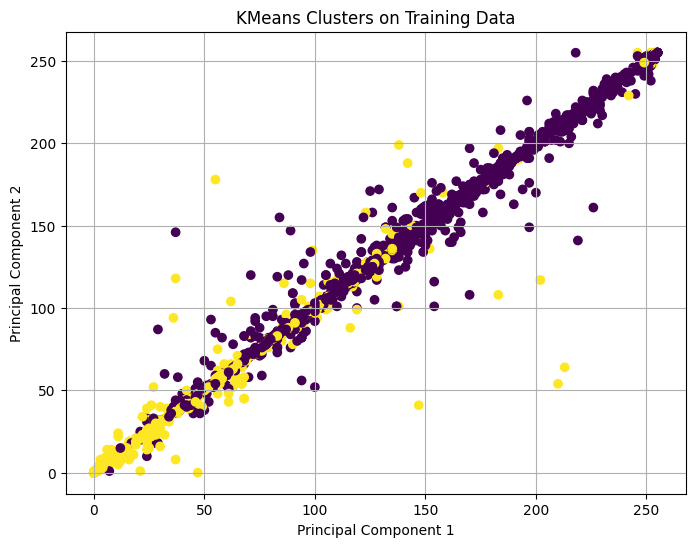

In [51]:
# build the clustering model without PCA data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# Predict cluster labels for training and testing data
y_train_kmeans = kmeans.predict(X_train)
y_test_kmeans = kmeans.predict(X_test)

# Create a scatter plot for training data colored by cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_kmeans, cmap="viridis")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans Clusters on Training Data")
plt.grid(True)
plt.show()

# t-SNE
PCA did not show clear clustering, suggesting that the data is not linear. What if t-SNE is used?

In [53]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)

C:\Users\rsant\AppData\Local\Temp\ipykernel_23820\3790783899.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", num_colors)


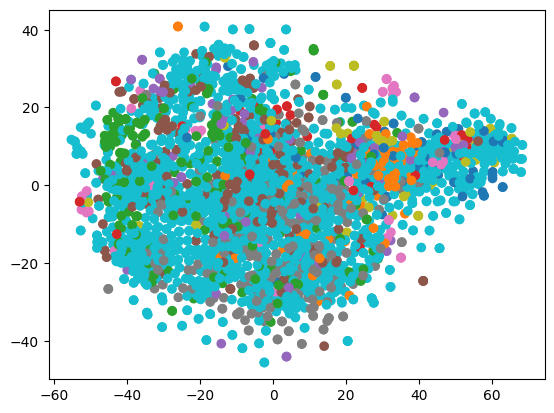

In [54]:
cmap = cm.get_cmap("tab20", num_colors)

# Plot t-SNE results
plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=plt.cm.tab10(y_train_int))

This looks worse. What about Isomap?

# Isomap

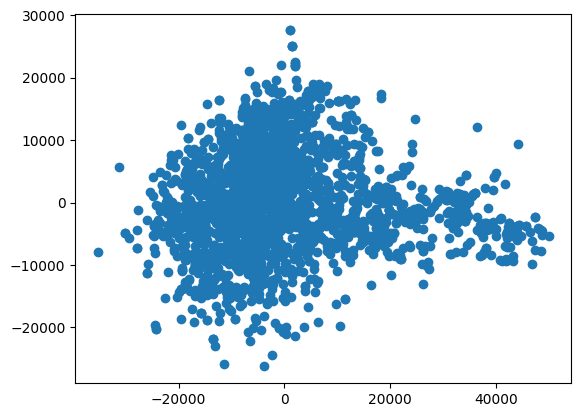

In [55]:
isomap = Isomap()
x_isomap = isomap.fit_transform(X_train_pca)
plt.figure()
plt.scatter(x_isomap[:, 0], x_isomap[:, 1])

Looks like there are no distinct clusters once again suggesting the data is non-linear.

# SVM

In [56]:
svm = SVC(kernel="rbf")
svm.fit(X_train, y_train)

# Predict cluster labels for training and testing data
y_pred_svm = svm.predict(X_test)

In [57]:
print("Accuracy on training data:")
print(accuracy_score(y_train, svm.predict(X_train)))

print("\nAccuracy on testing data:")
print(accuracy_score(y_test, y_pred_svm))

print("\nClassification report:")
print(classification_report(y_test, y_pred_svm))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Accuracy on training data:
0.7701838529176659

Accuracy on testing data:
0.45852749301025164

Classification report:
                                         precision    recall  f1-score   support

                              akhenaten       0.50      0.30      0.37        30
                 amenhotep_iii_and_tiye       0.31      0.48      0.38        29
               bent_pyramid_for_senefru       0.52      0.50      0.51       102
                    bust_of_ramesses_ii       0.75      0.27      0.40        33
         colossal_statue_of_ramesses_ii       0.46      0.21      0.29        28
                     colossoi_of_memnon       0.47      0.57      0.52        68
            goddess_isis_with_her_child       0.83      0.69      0.75        29
                             hatshepsut       0.44      0.58      0.50       110
                        hatshepsut_face       0.60      0.23      0.33        26
                         khafre_pyramid       0.40      0.74      0.52  

c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rsant\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,